<a href="https://colab.research.google.com/github/aerjayc/mu-visualize/blob/main/dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import csv
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly

In [ ]:
!git clone https://github.com/aerjayc/mu-api.git
!cp -r mu-api/mangaupdates .
!wget https://github.com/aerjayc/mu-visualize/raw/main/top.json
!wget https://github.com/aerjayc/mu-visualize/raw/main/top1k.csv

In [5]:
csvfname = 'top1k.csv'
data = pd.read_csv(csvfname)
with open('top.json') as f:
  stuff = json.loads(f.read())

In [197]:
series = pd.DataFrame([dict((k, stuff[sid][k]) for k in ('id', 'title', 'genres')) for sid in stuff.keys()])
# TODO: number of users, argument to size of point

In [198]:
genre_names = set()
for g in series.genres:
  genre_names = unique_genres.union(set(g))
genres = pd.DataFrame(False, columns=genre_names, index=range(len(series)))
for i, gs in enumerate(series['genres']):
  for n in genre_names:
    if n in gs:
      genres.loc[i][n] = True
series = series.drop('genres', 1).join(genres)
series

,id,title,Fantasy,Sci-fi,Ecchi,Martial Arts,Romance,Horror,Smut,Adult,Slice of Life,Supernatural,School Life,Mystery,Gender Bender,Comedy,Historical,Action,Drama,Harem,Sports,Psychological,Adventure,Mature,Seinen,Shoujo,Mecha,Tragedy,Shounen
0,5,Yotsubato!,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True
1,15,Naruto,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,True,False,False,False,True,False,False,False,False,False,True
2,16,Hunter Hunter,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True,False,False,True,True,False,False,False,False,True,True
3,33,One Piece,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,True,False,False,False,True,False,False,False,False,False,True
4,35,Bleach,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,True,False,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,109745,Re:Monster,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,True,True,False,False,True,True,True,False,False,False,False
96,110083,Mushoku Tensei - Isekai Ittara Honki Dasu,True,False,True,False,True,False,False,False,False,False,False,False,False,True,False,True,True,True,False,False,True,False,True,False,False,False,False
97,112459,Boku no Hero Academia,True,True,False,False,False,False,False,False,False,True,True,False,False,True,False,True,True,False,False,False,False,False,False,False,False,False,True
98,116976,The New Gate,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,True,False,False,False,True,False,True,False,False,False,False


In [183]:
k = 100
top_k_sids = data['seriesid'].unique()[:k]
top_k_data = data[data['seriesid'].isin(top_k_sids)]
df = top_k_data[['userid', 'seriesid']]
series_ids = sorted(df['seriesid'].unique())
df = df.merge(series.rename(columns={'id': 'seriesid'}))

In [184]:
n = len(series_ids)
#iou_matrix = np.zeros((n,n))
iou_matrix = pd.DataFrame(columns=range(n), index=range(n))
io1_matrix = iou_matrix.copy()
io2_matrix = iou_matrix.copy()
for i, sid_1 in enumerate(series_ids):
    print(sid_1, ',', end=' ', sep='', flush=True)
    iou_matrix[i][i] = 1.0
    io1_matrix[i][i] = 1.0
    io2_matrix[i][i] = 1.0
    for j, sid_2 in enumerate(series_ids[i+1:], start=i+1):
        # calculate similarity/distance/affinity/etc. metric
        users_1 = set(df[df['seriesid'] == sid_1]['userid'])
        users_2 = set(df[df['seriesid'] == sid_2]['userid'])
        users = users_1 | users_2
        common_users = users_1 & users_2
        iou = len(common_users) / len(users)
        io1 = len(common_users) / len(users_1)
        io2 = len(common_users) / len(users_2)
        v = (round(io1, 3), round(iou, 3), round(io2, 3))
        iou_matrix[i][j] = iou
        iou_matrix[j][i] = iou
        io1_matrix[i][j] = io1
        io1_matrix[j][i] = io1
        io2_matrix[j][i] = io2
        io2_matrix[i][j] = io2

5, 15, 16, 33, 35, 88, 95, 183, 208, 366, 376, 387, 491, 574, 600, 778, 812, 947, 1037, 1258, 1568, 1679, 2291, 2824, 3058, 3793, 3867, 4111, 4771, 4989, 5762, 7109, 8161, 8996, 9708, 9709, 10829, 11243, 11931, 13176, 13582, 13626, 13856, 14809, 14963, 16482, 17308, 22343, 24388, 25832, 27467, 27841, 31454, 34771, 37308, 39200, 39406, 40870, 41265, 42727, 44445, 45009, 46331, 47446, 49160, 49450, 52028, 52253, 55901, 56588, 57641, 58941, 60093, 62667, 63043, 64917, 69210, 69388, 70051, 70263, 70671, 72210, 74942, 76715, 80345, 82239, 86766, 87515, 101942, 103058, 103618, 105098, 107199, 108009, 109553, 109745, 110083, 112459, 116976, 119910, 

In [185]:
rename_mapping = dict(zip(range(n), series_ids))
io1_matrix = io1_matrix.rename(columns=rename_mapping, index=rename_mapping)
io2_matrix = io2_matrix.rename(columns=rename_mapping, index=rename_mapping)
iou_matrix = iou_matrix.rename(columns=rename_mapping, index=rename_mapping)

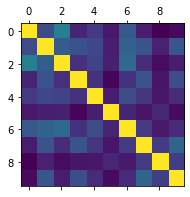

In [166]:
fig, ax = plt.subplots(figsize=(3,3))
cax = ax.matshow(np.array(iou_matrix, dtype='float'), interpolation='nearest')
plt.show()

In [186]:
from sklearn.metrics import pairwise_distances

user_preferences = pd.DataFrame(False, columns=df['seriesid'].unique(), index=df['userid'].unique(), dtype=bool)
for i, uid in enumerate(user_ids):
    indices = df[df['userid'] == uid]['seriesid']
    user_preferences.iloc[i][indices] = True

dis_matrix = pairwise_distances(user_preferences.to_numpy(), metric='jaccard')
dis_matrix.shape

(10371, 10371)

In [203]:
# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
components = pca.fit_transform(iou_matrix)
x,y,z = components.T[0], components.T[1], components.T[2]
components.shape

(100, 3)

In [205]:
sum(pca.explained_variance_ratio_)

0.44167905735656476

In [206]:
matrix = pd.DataFrame(np.hstack((components, df.seriesid.unique().reshape(-1,1))), columns=['x', 'y', 'z', 'id'])
matrix[['id']] = matrix[['id']].astype(int)
matrix = matrix.merge(series)
matrix

,x,y,z,id,title,Fantasy,Sci-fi,Ecchi,Martial Arts,Romance,Horror,Smut,Adult,Slice of Life,Supernatural,School Life,Mystery,Gender Bender,Comedy,Historical,Action,Drama,Harem,Sports,Psychological,Adventure,Mature,Seinen,Shoujo,Mecha,Tragedy,Shounen
0,0.287096,0.115324,0.221083,33,One Piece,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,True,False,False,False,True,False,False,False,False,False,True
1,0.487750,-0.511431,0.303728,35,Bleach,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,True,False,False,False,True,False,False,False,False,False,True
2,0.035707,-0.109274,0.591222,15,Naruto,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,True,False,False,False,True,False,False,False,False,False,True
3,0.021745,-0.190393,0.668660,47446,Shingeki no Kyojin,True,False,False,False,False,True,False,False,False,True,False,True,False,False,False,True,True,False,False,True,False,True,False,False,False,True,True
4,0.309394,-0.491227,0.368994,3793,Fairy Tail,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,True,False,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.741528,0.500237,0.093734,11931,Nurarihyon no Mago,True,False,False,False,False,False,False,False,False,True,True,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,True
96,-0.512401,0.604591,-0.024622,86766,Dragons Rioting,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,True,False,True,False,False,False,False,False,False,False,False,True
97,-0.273654,0.502064,0.387547,812,Hajime no Ippo,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,True,False,True,False,False,False,False,False,False,False,True
98,-0.505213,0.593277,0.014627,103058,UQ Holder!,True,False,True,False,True,False,False,False,False,False,False,False,False,True,False,True,True,True,False,False,True,False,False,False,False,False,True


In [213]:
for i, n in enumerate(genre_names):
  print(n, end=' ')
  if i % 8 == 7:
    print()

Fantasy Sci-fi Ecchi Martial Arts Romance Horror Smut Adult 
Slice of Life Supernatural School Life Mystery Gender Bender Comedy Historical Action 
Drama Harem Sports Psychological Adventure Mature Seinen Shoujo 
Mecha Tragedy Shounen 

In [219]:
import plotly.express as px

fig = px.scatter_3d(matrix, x='x', y='y', z='z', hover_name='title', color=matrix['Seinen'].map({False:'No', True:'Yes'}))
fig.show()

ValueError: ignored

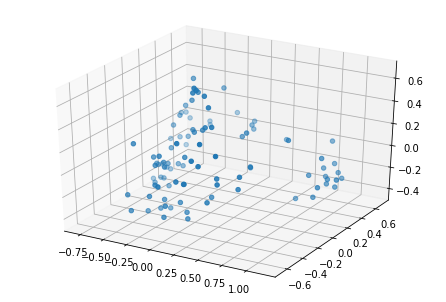

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(x,y,z)

for i, sid in enumerate(series_ids):
  label = stuff[str(sid)]['title']
  ax.annotate(label, (x[i], y[i], z[i]))

plt.show()

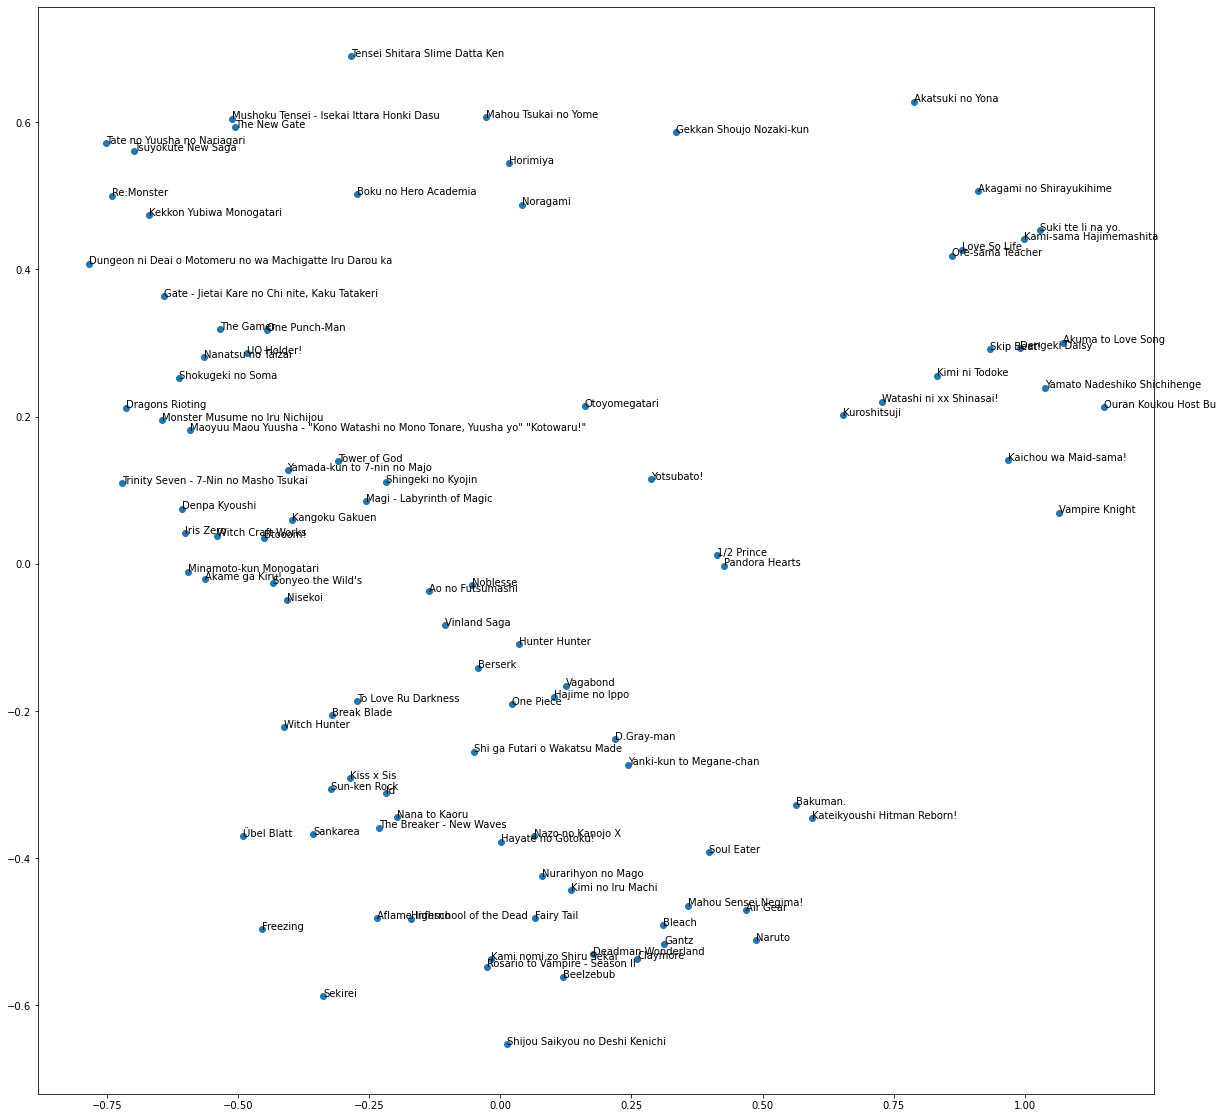

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(x,y)

for i, sid in enumerate(series_ids):
  label = stuff[str(sid)]['title']
  ax.annotate(label, (x[i], y[i]))

plt.show()

In [ ]:
import json
with open('top.json') as f:
  stuff = json.loads(f.read())

In [ ]:
stuff['33']['title']

'One Piece'

In [ ]:
mds_model = manifold.MDS(n_components=2, random_state=123, dissimilarity='precomputed')
mds_fit = mds_model.fit(dis_matrix)
mds_coords = mds_model.fit_transform(dis_matrix)

In [ ]:
import plotly.express as px
df = px.data.iris()
fig = px.scatter_3d(df, x='sepal_length', y='sepal_width', z='petal_width',
              color='species')
fig.show()


In [ ]:
import mangaupdates
import time


for i, sid in enumerate(series_ids[len(stuff):]):
    series = mangaupdates.Series(int(sid))
    print(sid, end=', ', flush=True)
    series.populate()
    stuff[int(sid)] = series
    time.sleep(10)
    json_str = series.json()
    with open(json_fname, 'a') as f:
        if i != 0:
            f.write(', ')
        print(f'"{sid}": {json_str}', file=f)

with open(json_fname, 'a') as f:
    f.write('}')